# Inference: Writing a custom prior

This example shows you how to write a custom [LogPrior](http://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPrior) class to use in your inference problems.

It follows on from the [basic MCMC example](./inference-first-example.ipynb).

Most priors in Pints are defined over just 1 parameter, and then combined into a multivariate prior using the [ComposedLogPrior](http://pints.readthedocs.io/en/latest/log_priors.html#pints.ComposedLogPrior) class.
But sometimes you might want to define a prior over multiple variables at once. In such a case, it may make sense to create a custom LogPrior class.

In this example, we'll implement a uniform 2d logprior that defines a circle in the parameter space such that points within the circle have probability c = 1/A and points outside it have probability 0.

Before we begin, let's define a toy problem, like in the basic MCMC example:

In [1]:
from __future__ import print_function
import pints
import pints.toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = np.array([1, 500])
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise)

Now let's add our prior.

First, we take a look at the [LogPrior](http://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPrior) class, as well as the [LogPDF](http://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPDF) class which it extends.

From this we learn that:

1. We need to provide a dimension() method that returns the dimension of the parameter space our prior is defined on
2. Objects of our prior class should be [callable](https://docs.python.org/3/reference/datamodel.html#object.__call__): they should have a `__call__` method that takes a parameter vector as input and returns a scalar.
3. If we like, we can implement an optional `sample()` method.

Leaving aside the `sample()` method, we can implement our prior like this:

In [2]:
class CircularPrior(pints.LogPrior):
    def __init__(self, center):
        # Store center
        self._center = np.array(center)
        # Set circle radius
        self._r = 1
        # Calculate c        
        A = np.pi * self._r * self._r
        self._c = np.log(1 / A)
    
    def dimension(self):
        return 2
    
    def __call__(self, parameters):
        # Get coordinates relative to center
        p = np.array(parameters) - self._center
        
        # Calculate the radius
        r = np.sqrt(p[0]*p[0] + p[1]*p[1])
        
        # Return
        return self._c if r < self._r else 0
        

Now we can test our prior with a few values:

In [3]:
p = CircularPrior([0, 0])
print(p([0, 0]))         # c
print(p([1, 1]))         # 0
print(p([-0.5, -0.5]))   # c
print(p([-1.0, 0]))      # 0
print(p([0.9, 0]))       # c

-1.14472988585
0
-1.14472988585
0
-1.14472988585


Now we can try using it in an inference routine:

Running...
Done!
R-hat:
[0.99979463861074069, 1.0022762361734321]


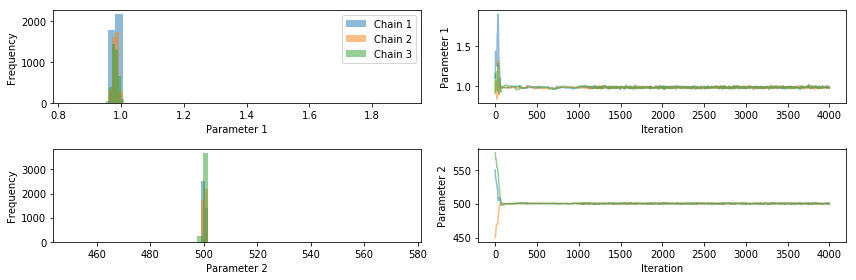

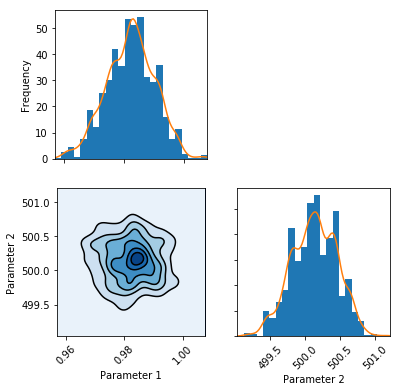

In [4]:
# Create a log-prior
log_prior = CircularPrior(center=real_parameters)

# Create a posterior log-likelihood (log(prior * likelihood))
log_posterior = pints.LogPosterior(log_prior, log_likelihood)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_adaptation_free_iterations(1000)

# Disable verbose mode
mcmc.set_verbose(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(*chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()